In [1]:
import os 

import numpy as np
import scipy.stats as sps
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

import sys, os
sys.path += [os.path.abspath(os.pardir + '/code')]
print(sys.path)

from experiment import init_random_state, BanditLoopExperiment, get_ts_model

sns.set(font_scale=1.2, palette='tab20') 

['/home/anton/Desktop/m1p/2021-Project-74/notebooks', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/anton/.local/lib/python3.8/site-packages', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/home/anton/.local/lib/python3.8/site-packages/IPython/extensions', '/home/anton/.ipython', '/home/anton/Desktop/m1p/2021-Project-74/code']


In [2]:
def draw_posteriori(grid, distr_class, post_params, obj, steps, xlim=None):
    '''Рисует серию графиков апостериорных плотностей.
    
    :param grid: сетка для построения графика
    :param distr_class: класс распределений из scipy.stats
    :param post_params: параметры апостериорных распределений 
        shape=(размер выборки, кол-во параметров)
    '''
    
    size = post_params.shape[0] - 1
    plt.figure(figsize=(12, 7))
    for n, t in enumerate(steps):
        plt.plot(grid, 
                 distr_class(post_params[n]).pdf(grid) \
                     if np.isscalar(post_params[n]) \
                     else distr_class(*post_params[n]).pdf(grid), 
                 label='t={}: {}'.format(t, np.round(post_params[n], 3)), 
                 lw=2.5,
                 color=(1-n/size, n/size, 0))
    plt.title(f'Апостериорное распределение для объекта {obj} в зависимости от шага')
    plt.grid(ls=':')
    plt.legend(fontsize=12)
    plt.xlim(xlim)
    plt.show()

In [3]:
seed = 42

p = 0.9
Q = 1
ws = np.logspace(0, 2, 7)
b = 0.0

T = 2000
M = 10
l = 4

In [4]:
interests, TS_paramss, responses = [], [], []

In [5]:
for w in ws:
    init_random_state(seed)
    
    bandit = lambda: get_ts_model(M=M, l=l)
    exp = BanditLoopExperiment(bandit, "TS bandit")
    exp.prepare(w=w, Q=Q, p=p, b=b)
    exp.run_experiment(T=T)
    
    results = exp.get_as_np()
    interests.append(results.interest)
    TS_paramss.append(results.TS_params)
    responses.append(results.response)

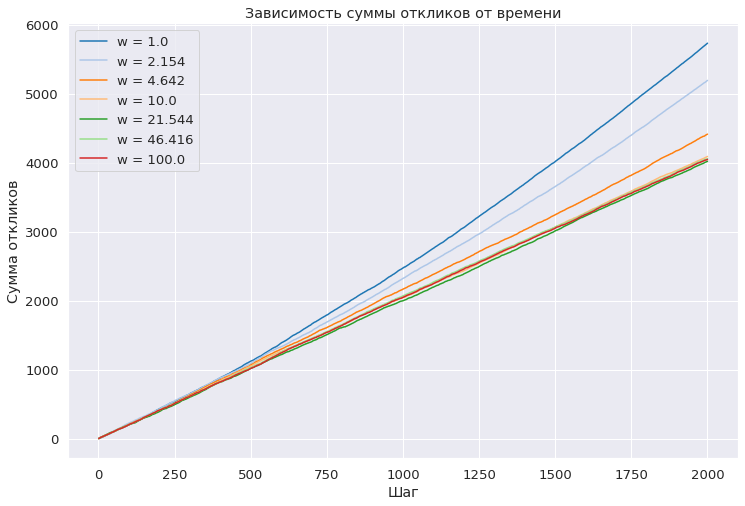

In [6]:
sum_responces = []
for  i, w in enumerate(ws):
    sum_responces.append(np.cumsum(responses[i].sum(axis=1)))
plt.figure(figsize=(12, 8))
for i, w in enumerate(ws):
    plt.plot(np.arange(1, T+1), sum_responces[i], label=f'w = {round(w,3)}')

plt.title('Зависимость суммы откликов от времени')
plt.ylabel('Сумма откликов')
plt.xlabel('Шаг')
plt.legend()
plt.savefig('rewards.pdf')

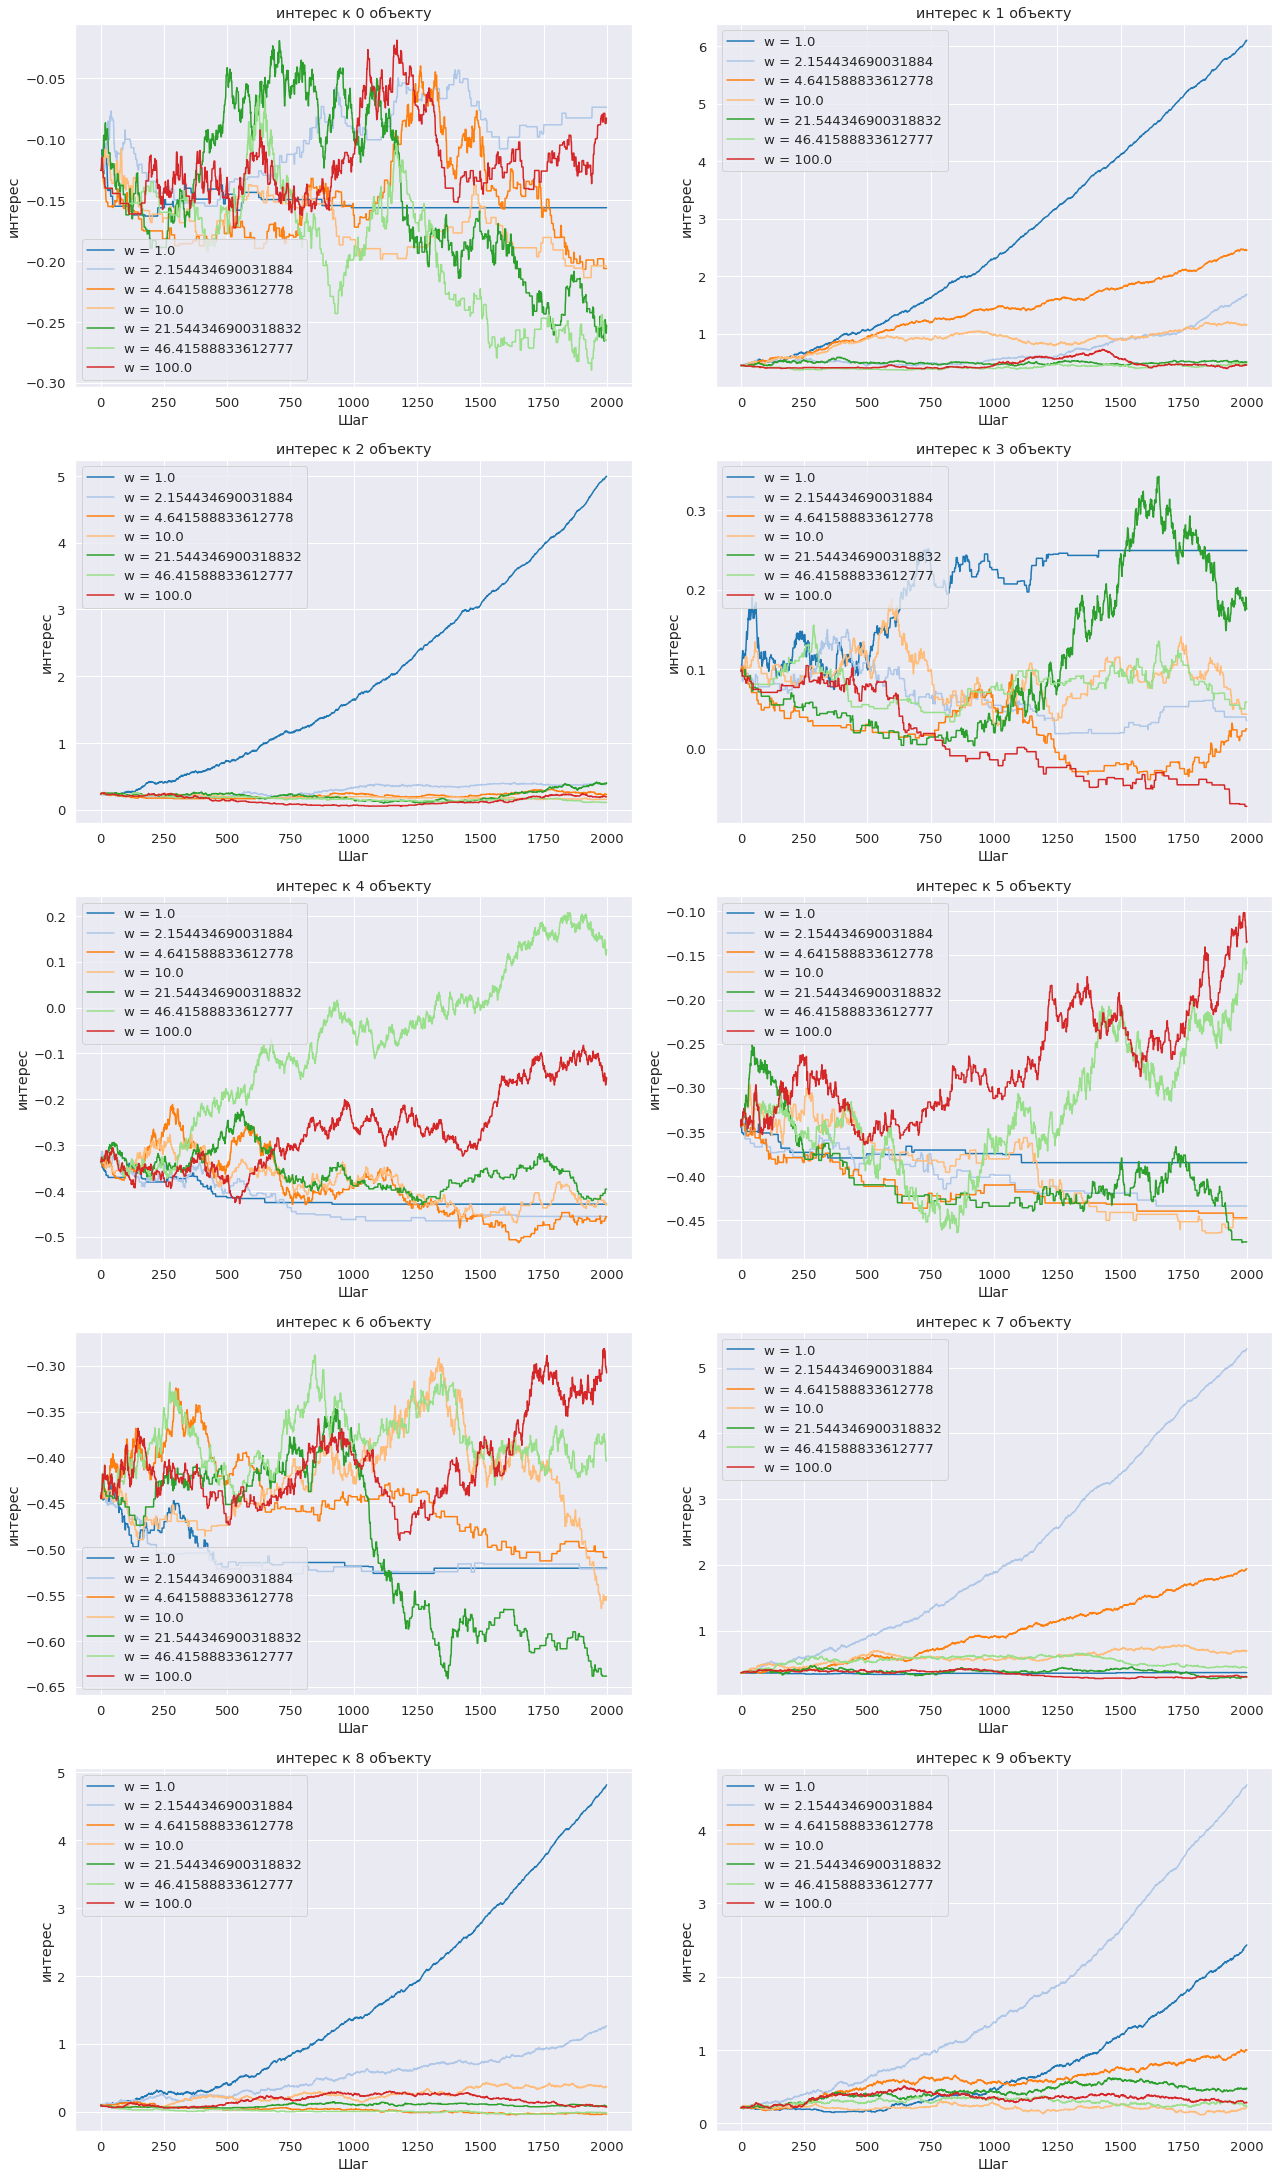

In [7]:
plt.figure(figsize=(18, 36))
for m in range(M):
    plt.subplot(M // 2 + 1, 2, m+1)
    for i, w in enumerate(ws):
        plt.plot(interests[i][:, m], label=f'w = {w}')
    plt.title(f'интерес к {m} объекту')
    plt.ylabel('интерес')
    plt.xlabel('Шаг')
    plt.legend()

    plt.tight_layout()

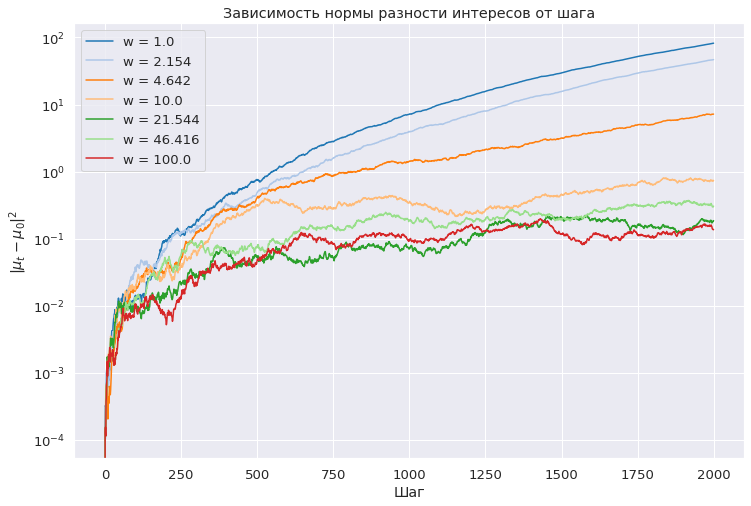

In [8]:
plt.figure(figsize=(12, 8))
for i, w in enumerate(ws):
    plt.plot(np.linalg.norm(interests[i] - interests[i][0], axis=1)**2, label=f'w = {round(w,3)}')
plt.yscale('log')
plt.ylabel(r'$\|\mu_t - \mu_0 \|^2$')
plt.title('Зависимость нормы разности интересов от шага')
plt.legend()
plt.xlabel('Шаг')
plt.savefig('norm_interest.pdf')